# Putting our models to use

-----


## 1. Classify which side play art is on using previously trained model

In [6]:
import os
import pandas as pd


def construct_test_dataset(test_dir):
    filenames = []
    for root, dirs, files in os.walk(test_dir, topdown=True):
            for name in files:
                filenames.append(os.path.join(root, name))


    filenames = [f for f in filenames if 'DS_Store' not in f]
    df = pd.DataFrame({'filename': filenames})
    df.reset_index(drop=True, inplace=True)

    fn = f'csv/test_data_{test_dir.split("/")[-1]}.csv'
    df.to_csv(fn)
    return fn

In [7]:
from torch.utils.data import Dataset
import cv2 as cv


class PlaySideDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        '''
        '''
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        self.transform = transform
        self.size = (300,100)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = self.dataframe.iloc[idx, 0]
        
        image = cv.imread(img_name)
        #image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        #
        image = cv.resize(image, self.size)

        if self.transform:
            image = self.transform(image)
        
        return image

In [8]:
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)),
                           ])


side_dir = 'image_data/test/saved_plays'
filename = construct_test_dataset(side_dir)

dset = PlaySideDataset(filename, trans)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(19584, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 19584)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [11]:
import torch

validation_loader = torch.utils.data.DataLoader(dset, batch_size=len(dset.dataframe))

batch = next(iter(validation_loader))
model = Net()
model.load_state_dict(torch.load('side_model.pt'))
model.eval()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predictions = []

with torch.no_grad():
    
        images = batch
        images = images.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        predictions.extend(argmax)

In [16]:
preds = [_.item() for _ in predictions]

pdf = pd.DataFrame({'pred': preds})
pdf['pred'].value_counts()

2    387
0    322
1    207
Name: pred, dtype: int64

In [25]:
df = dset.dataframe.copy()
df['side'] = preds

In [28]:
int_to_label_map = {0: 'left', 1: 'neither', 2: 'right'}
df['side'] = df['side'].apply(lambda x: int_to_label_map[x])

In [29]:
df.head()

,filename,side
0,image_data/test/saved_plays/Madden NFL 19_2019...,left
1,image_data/test/saved_plays/Madden NFL 19_2018...,right
2,image_data/test/saved_plays/Madden NFL 19_2019...,right
3,image_data/test/saved_plays/Madden NFL 19_2019...,right
4,image_data/test/saved_plays/Madden NFL 19_2019...,left


In [30]:
df.to_csv('csv/test_data_side.csv')

## 2. Classify play type
label_map = {'pass': 0, 'run': 1, 'fake': 2}

In [66]:
class PlayTypeDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        '''
        '''
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        self.dataframe = self.dataframe[self.dataframe['side'] != 'neither'].reset_index(drop=True)
        self.transform = transform
        self.size = (150, 100)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        side = self.dataframe.iloc[idx, 1]
        image = cv.imread(img_name)
        cut_idx = int(image.shape[1]/2)

        if side == 'left':
            image = image[:, :cut_idx]
        elif side == 'right':
            image = image[:, cut_idx:]
        else:
            print('ERROR')
            
        image = cv.resize(image, self.size)

        if self.transform:
            image = self.transform(image)
                
        return image

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class PlayTypeNet(nn.Module):
    def __init__(self):
        super(PlayTypeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(10880, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 10880)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [68]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)),
                           ])

play_dset = PlayTypeDataset('csv/test_data_side.csv', trans)

In [88]:
validation_loader2 = torch.utils.data.DataLoader(play_dset, batch_size=len(play_dset))

batch2 = next(iter(validation_loader2))
model2 = PlayTypeNet()
model2.load_state_dict(torch.load('playtype_model_halved.pt'))
model2.eval()

PlayTypeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=10880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)

In [89]:
predictions2 = []

with torch.no_grad():
    
        images = batch2
        images = images.to(device)
        
        # Forward pass
        outputs = model2(images.float())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        predictions2.extend(argmax)

In [90]:
preds2 = [_.item() for _ in predictions2]

pdf2 = pd.DataFrame({'pred': preds2})
pdf2['pred'].value_counts()

0    455
1    232
2     22
Name: pred, dtype: int64

In [92]:
tempdf = df.copy()
tempdf = tempdf[ tempdf['side'] != 'neither']
tempdf['play_type'] = preds2

In [99]:
int_to_play_map = {0: 'pass', 1: 'run', 2: 'fake'}
tempdf['play_type'] = tempdf['play_type'].apply(lambda x: int_to_play_map[x])

In [117]:
temp = [{'filename': row[1][0], 
         'side': row[1][1],
         'play': row[1][2] } 
        for row in tempdf.iterrows()]

In [125]:
tempdf.to_csv('csv/final_predictions.csv')

## Results

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import cv2

def cut_image(image, side):
    cut_idx = int(image.shape[1]/2)

    if side == 'left':
        image = image[:, :cut_idx]
    else:
        image = image[:, cut_idx:]
    return image

def show_result(temp):
    show_image(temp['filename'], temp['side'] + '-' + temp['play'])
    
def get_image(img_path, side):
    image = cv2.imread(img_path)
    image = cut_image(image, side)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

def show_results(temp):
    nrows, ncols = 4, 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 15))
    k=0
    for i in range(nrows):
        for j in range(ncols):
            axs[i][j].set_title(temp[k]['side'] + '-' + temp[k]['play'])
            axs[i][j].imshow(get_image(temp[k]['filename'], temp[k]['side']))
    
            axs[i][j].tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False ) # labels along the bottom edge are off
            k+=1
    plt.show()

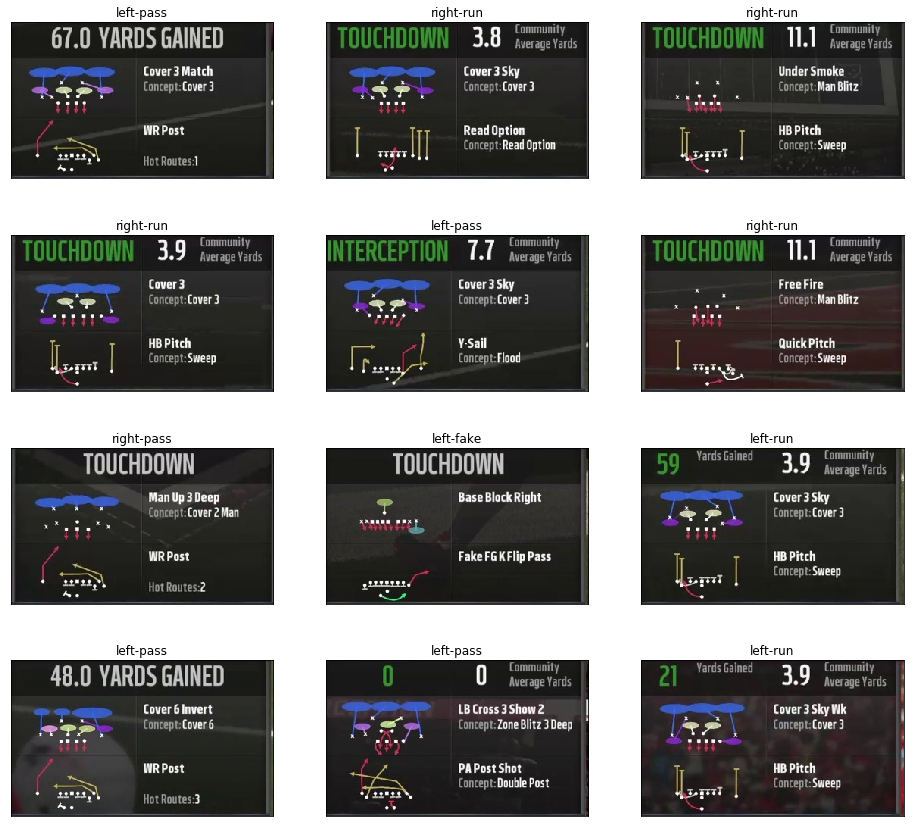

In [169]:
show_results(temp)

### SUCCESS!

In [166]:
temp2 = [{'filename': row[1][0], 
         'side': row[1][1],
         'play': row[1][2] } 
        for row in tempdf[ tempdf['play_type']=='fake'].iterrows()]

The bottom right play is not a fake but the rest are well predicted:

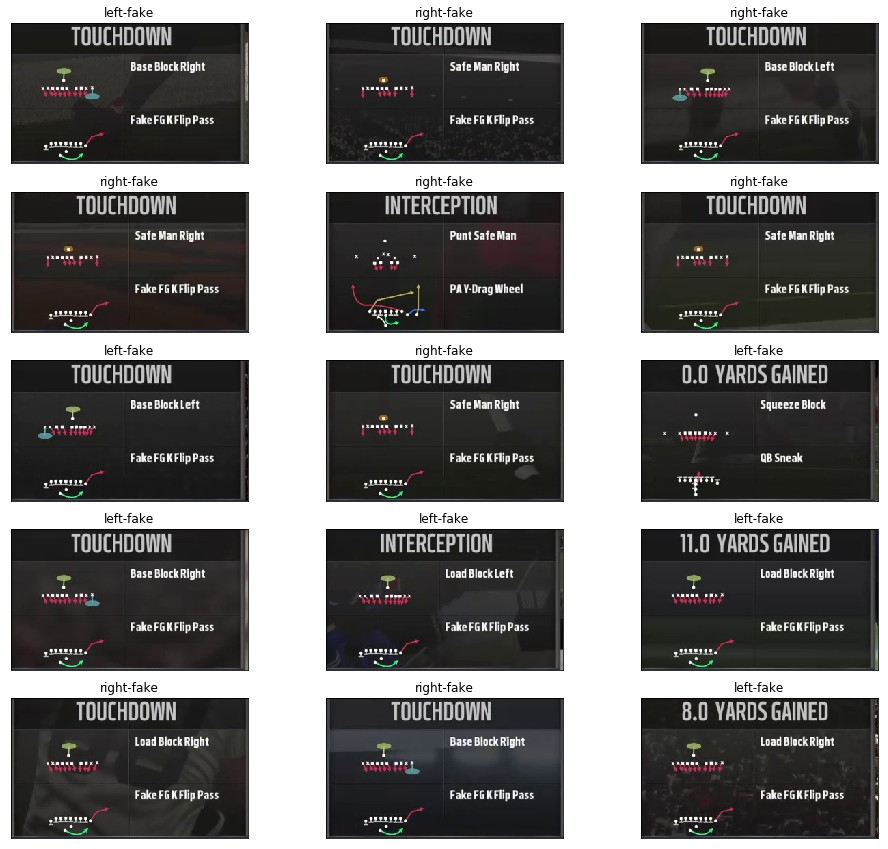

In [167]:
show_results(temp2)